## Import Libraries and Read Point Cloud

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Read the point cloud
pcd = o3d.io.read_point_cloud(r"C:\Users\Aadii\Downloads\CSite1_orig-utm.pcd")
points = np.asarray(pcd.points)
print(pcd)
print('Shape of points', np.asarray(pcd.points).shape)
print('Shape of colors', np.asarray(pcd.colors).shape) # no color data


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PointCloud with 1366408 points.
Shape of points (1366408, 3)
Shape of colors (0, 3)


## Implement the RANSAC algorithm to find the largest plane

In [2]:
def ransac_plane(points, max_iterations=1000, distance_threshold=0.01):
    best_plane = None
    max_inliers = 0
    
    for _ in range(max_iterations):
        # Randomly sample 3 points
        sample = points[np.random.choice(points.shape[0], 3, replace=False)]
        
        # Calculate plane equation (ax + by + cz + d = 0)
        v1 = sample[1] - sample[0]
        v2 = sample[2] - sample[0]
        normal = np.cross(v1, v2)
        a, b, c = normal
        d = -np.dot(normal, sample[0])
        
        # Calculate distances of all points to the plane
        distances = np.abs(np.dot(points, normal) + d) / np.linalg.norm(normal)
        
        # Count inliers
        inliers = np.sum(distances < distance_threshold)
        
        if inliers > max_inliers:
            max_inliers = inliers
            best_plane = (a, b, c, d)
    
    return best_plane, max_inliers

# Find the largest plane
best_plane, num_inliers = ransac_plane(points)

## Extract the inlier points of the largest plane

In [3]:
a, b, c, d = best_plane
distances = np.abs(np.dot(points, [a, b, c]) + d) / np.linalg.norm([a, b, c])
inlier_mask = distances < 0.01
inlier_points = points[inlier_mask]

## Calculate the surface area of the plane

In [4]:
from scipy.spatial import ConvexHull

def calculate_plane_area(inlier_points):
    # Project points onto the plane
    normal = np.array([a, b, c])
    projected_points = inlier_points - np.outer(np.dot(inlier_points, normal) + d, normal) / np.dot(normal, normal)
    
    # Calculate the convex hull of the projected points
    hull = ConvexHull(projected_points[:, :2])  # Use only x and y coordinates
    
    return hull.area

plane_area = calculate_plane_area(inlier_points)
print(f"Plane surface area: {plane_area:.2f} square units")

Plane surface area: 2774.33 square units


## Plot the original point cloud and the extracted plane

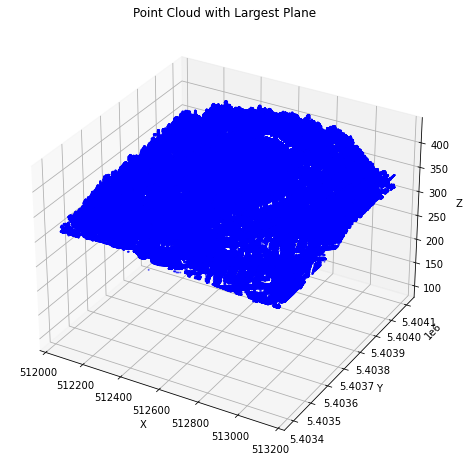

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original point cloud
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', s=1, alpha=0.5)

# Plot inlier points (plane)
ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], c='r', s=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud with Largest Plane')

plt.show()